In [0]:
import torch
from statistics import mean
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal
import matplotlib.pyplot as plt
import pandas as pd
import json
pyro.set_rng_seed(45)

# Daggity Model
![alt text](https://drive.google.com/uc?id=1-rcNgrrXaocDoljyXUvqyr1TYO9SJ0Eh)

 ROI Calculation = 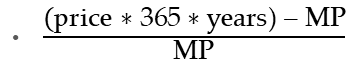

# CPT from Bnlearn to Pyro

Let us now try the Naive approach to dump all the CPTs into a '.json' file from R and then deserialize it in python to build our model. We implemented a generic function to migrate CPTs from Bnlearn R to Pyro. The input is the Json file 'test.json' created in R using the JSONIO library.


```
> exportJson <- toJSON(bn_dag)
> write(exportJson, "test.json")
```


In [0]:
import json

def converToValues(obj):
    if isinstance(obj, list):
        for index, item in enumerate(obj):
            newitem = converToValues(item)
            obj[index] = newitem
    elif isinstance(obj,dict):
        return list(obj.values())

    return obj

def convertToTransposeElemts(obj):
    if isinstance(obj,list):
        for index, item in enumerate(obj):
            if isinstance(item[0],list):
                newArray = convertToTransposeElemts(item)
                obj[index] = newArray
            else:
                temp = [list(x) for x in zip(*obj)]
                return temp
    return obj


with open('test.json') as f:
    data_dict = json.load(f)



## Fetching the Probabilities

After you have succesfully loaded the file import you features. As we are not aware of the feature names, You need to provide the names of your feature and it will extract the CPTs for you, to be used to build your model. Find the below code, we have used to parse our test.json for your reference

In [0]:
zipcode_prob = torch.tensor(data_dict['zipcode']['prob'])
pets_prob = torch.tensor(data_dict['pets']['prob'])
apartment_prob = torch.tensor(data_dict['apartment_age']['prob'])


room_type_prob = converToValues(data_dict['room_type']['prob'])
room_type_prob = torch.tensor(convertToTransposeElemts(room_type_prob))

proximity_score_prob = converToValues(data_dict['proximity_score']['prob'])
proximity_score_prob = torch.tensor(convertToTransposeElemts(proximity_score_prob))

review_scores_rating_prob = converToValues(data_dict['review_scores_rating']['prob'])
review_scores_rating_prob = torch.tensor(convertToTransposeElemts(review_scores_rating_prob))

amenities_score_prob = converToValues(data_dict['amenities_score']['prob'])
amenities_score_prob = torch.tensor(convertToTransposeElemts(amenities_score_prob))

cleaning_fee_prob = converToValues(data_dict['cleaning_fee']['prob'])
cleaning_fee_prob = torch.tensor(convertToTransposeElemts(cleaning_fee_prob))

bedroom_prob = converToValues(data_dict['bedrooms']['prob'])
bedroom_prob = torch.tensor(convertToTransposeElemts(bedroom_prob))

bathroom_prob = converToValues(data_dict['bathrooms']['prob'])
bathroom_prob = torch.tensor(convertToTransposeElemts(bathroom_prob))

price_prob = converToValues(data_dict['price']['prob'])
price_prob = torch.tensor(convertToTransposeElemts(price_prob))

cost_property_prob = converToValues(data_dict['cost_property']['prob'])
cost_property_prob = torch.tensor(convertToTransposeElemts(cost_property_prob))

ROI_prob = converToValues(data_dict['ROI']['prob'])
ROI_prob = torch.tensor(convertToTransposeElemts(ROI_prob))

# Build Your Model

In [4]:
def model():
 
 zipcode = pyro.sample("zipcode", dist.Categorical(probs=zipcode_prob))
 pets = pyro.sample("pets", dist.Categorical(probs=pets_prob))
 apartment_age = pyro.sample("apartment_age", dist.Categorical(probs=apartment_prob))

 room_type = pyro.sample("room_type", dist.Categorical(probs=room_type_prob[zipcode]))
 proximity_score = pyro.sample("proximity_score", dist.Categorical(probs=proximity_score_prob[zipcode]))
 amenities_score = pyro.sample("amenities_score", dist.Categorical(probs=amenities_score_prob[apartment_age]))
 cleaning_fee = pyro.sample("cleaning_fee", dist.Categorical(probs=cleaning_fee_prob[pets]))
 bedrooms = pyro.sample("bedrooms", dist.Categorical(probs=bedroom_prob[room_type]))
 bathrooms = pyro.sample("bathrooms", dist.Categorical(probs=bathroom_prob[room_type]))

 review_scores_rating = pyro.sample("review_scores_rating", dist.Categorical(probs=review_scores_rating_prob[amenities_score][zipcode]))
 price = pyro.sample("price", dist.Categorical(probs=price_prob[zipcode][proximity_score][pets][review_scores_rating][room_type][cleaning_fee]))
 cost_property = pyro.sample("cost_property", dist.Categorical(probs=cost_property_prob[zipcode][proximity_score][room_type][apartment_age][bedrooms][bathrooms]))
 ROI = pyro.sample("ROI", dist.Categorical(probs=ROI_prob[price][cost_property]))

 return{'zipcode' : zipcode, 'pets' : pets, 'apartment_age' : apartment_age, 'room_type' : room_type, 
        'proximity_score' : proximity_score, 'amenities_score': amenities_score, 'cleaning_fee': cleaning_fee , 
        'bedrooms': bedrooms, 'bathrooms':bathrooms, 'review_scores_rating':review_scores_rating, 
        'price':price,'cost_property': cost_property,'ROI':ROI}
print(model())

{'zipcode': tensor(1), 'pets': tensor(0), 'apartment_age': tensor(0), 'room_type': tensor(0), 'proximity_score': tensor(2), 'amenities_score': tensor(1), 'cleaning_fee': tensor(1), 'bedrooms': tensor(2), 'bathrooms': tensor(0), 'review_scores_rating': tensor(1), 'price': tensor(0), 'cost_property': tensor(2), 'ROI': tensor(2)}


# Interventions

### Bedrooms on ROI ( ROI | do(bedrooms=2) ) and Bedrooms on ROI ( ROI | do(bedrooms=5) ) 
We intervened on number of bedrooms to identify the causal effect of number of bedrooms. We want to know the effect having more number of bedrooms i.e 5 and average number of bedrooms i.e 2

Text(0.5, 1.0, 'P(ROI | do(bedrooms =2)) - Importance Sampling')

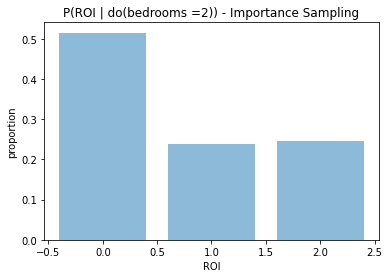

In [5]:
condition = pyro.do(model,data ={'bedrooms':torch.tensor(1)})
posterior = pyro.infer.Importance(condition, num_samples = 5000).run()
marginal = EmpiricalMarginal(posterior,"ROI")
samples = [marginal().item() for _ in range(1000)]
unique, counts = np.unique(samples,return_counts =True)
plt.bar(unique,counts/1000,align = 'center',alpha = 0.5 )
plt.ylabel('proportion')
plt.xlabel('ROI')
plt.title('P(ROI | do(bedrooms =2)) - Importance Sampling')

Text(0.5, 1.0, 'P(ROI | do(bedrooms =5)) - Importance Sampling')

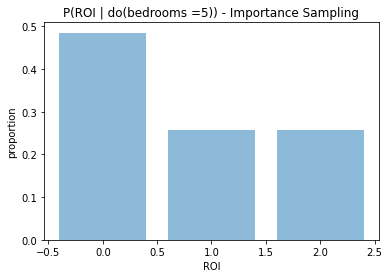

In [6]:
condition = pyro.do(model,data ={'bedrooms':torch.tensor(4)})
posterior = pyro.infer.Importance(condition, num_samples = 5000).run()
marginal = EmpiricalMarginal(posterior,"ROI")
samples = [marginal().item() for _ in range(1000)]
unique, counts = np.unique(samples,return_counts =True)
plt.bar(unique,counts/1000,align = 'center',alpha = 0.5 )
plt.ylabel('proportion')
plt.xlabel('ROI')
plt.title('P(ROI | do(bedrooms =5)) - Importance Sampling')


To verify this result we checked the zestimate graph on Zillow for two of our Data in Zilker Area, Austin, TX, 78704. We observe that the both the properties 2 Bed and 5 Bed were purchased in same price of $$450K but its value today is More than $1M for a % Bed Apartment and much less than a million for a 2 Bed Apartment





2 Bedroom House
![alt text](https://drive.google.com/uc?id=1iFRcqduuYJVVOEgK_aEbmfeegcMb0o7m)

5 Bedroom House
![alt text](https://drive.google.com/uc?id=15UA4Nsos9zw7YJ4r6h_1GJrB4Q6mV0z4)

### Room Type on ROI ( ROI | do(Room Type = 'Entire Home/apt') )  and ( ROI | do(Room Type = 'Private Room') )

We intervened on Type of Room put up on Airbnb Listing to identify its causal effect on ROI. It is better to rent an Entire Apartment than to rent only a Room

Text(0.5, 1.0, 'P(ROI | do(room_type =Entire home/apt)) - Importance Sampling')

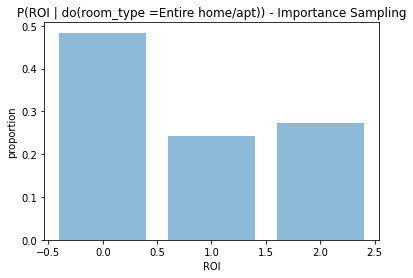

In [7]:
condition = pyro.do(model,data ={'room_type':torch.tensor(0)})
posterior = pyro.infer.Importance(condition, num_samples = 5000).run()
marginal = EmpiricalMarginal(posterior,"ROI")
samples = [marginal().item() for _ in range(1000)]
unique, counts = np.unique(samples,return_counts =True)
plt.bar(unique,counts/1000,align = 'center',alpha = 0.5 )
# plt.xticks(unique,A_alias)
plt.ylabel('proportion')
plt.xlabel('ROI')
plt.title('P(ROI | do(room_type =Entire home/apt)) - Importance Sampling')

Text(0.5, 1.0, 'P(ROI | do(room_type =Private room)) - Importance Sampling')

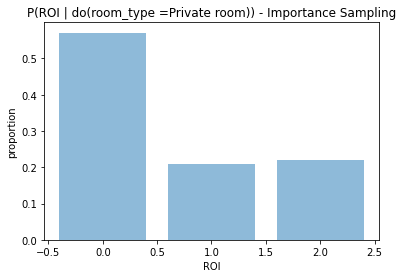

In [8]:
condition = pyro.do(model,data ={'room_type':torch.tensor(1)})
posterior = pyro.infer.Importance(condition, num_samples = 5000).run()
marginal = EmpiricalMarginal(posterior,"ROI")
samples = [marginal().item() for _ in range(1000)]
unique, counts = np.unique(samples,return_counts =True)
plt.bar(unique,counts/1000,align = 'center',alpha = 0.5 )
# plt.xticks(unique,A_alias)
plt.ylabel('proportion')
plt.xlabel('ROI')
plt.title('P(ROI | do(room_type =Private room)) - Importance Sampling')

To verify this result we checked the Airbnb Listing for two of our Data Points. We observe that the A private room costs only \$25 whereas entire apartment would cost $60 per day. Which is more than doble the cost of renting a private room.

# Back Door Criteria  

To observe the causal Effect of Amenities Score on ROI we conditioned on the Apartment Age(Parent Adjustment Set). We can find the minimal adjusment set for blocking backdoor path with adjustment set function from dagitty package(It is shown in the R markdown tutorial). We get {apartment age} as one of the adjustment set. Also apartment_age satifies the parent adjustment criteria, therefore conditioning on apartment age will block all the backdoor paths. And then we can find the average causal effect of amenities on ROI.

![alt text](https://drive.google.com/uc?id=140dMexMoLP9tTlWqQBxu3r4Itk6gbz_7)

In [0]:
condition_X0_Z0 = pyro.condition(model,data ={'amenities_score':torch.tensor(0),'apartment_age':torch.tensor(0)})
condition_X0_Z0_samples = [
    1 if condition_X0_Z0()['ROI'] == 2.0 else 0
    for _ in range(50000)
]

P_X0_Z0 = mean(condition_X0_Z0_samples) * float(apartment_prob[0])

condition_X0_Z1 = pyro.condition(model,data ={'amenities_score':torch.tensor(0),'apartment_age':torch.tensor(1)})
condition_X0_Z1_samples = [
    1 if condition_X0_Z1()['ROI'] == 2.0 else 0
    for _ in range(50000)
]

P_X0_Z1 = mean(condition_X0_Z1_samples) * float(apartment_prob[1])

condition_X0_Z2 = pyro.condition(model,data ={'amenities_score':torch.tensor(0),'apartment_age':torch.tensor(2)})
condition_X0_Z2_samples = [
    1 if condition_X0_Z2()['ROI'] == 2.0 else 0
    for _ in range(50000)
]

P_X0_Z2 = mean(condition_X0_Z2_samples) * float(apartment_prob[2])


condition_X1_Z0 = pyro.condition(model,data ={'amenities_score':torch.tensor(2),'apartment_age':torch.tensor(0)})
condition_X1_Z0_samples = [
    1 if condition_X1_Z0()['ROI'] == 2.0 else 0
    for _ in range(50000)
]


P_X1_Z0 = mean(condition_X1_Z0_samples) * float(apartment_prob[0])

condition_X1_Z1 = pyro.condition(model,data ={'amenities_score':torch.tensor(2),'apartment_age':torch.tensor(1)})
condition_X1_Z1_samples = [
    1 if condition_X1_Z1()['ROI'] == 2.0 else 0
    for _ in range(50000)
]

P_X1_Z1 = mean(condition_X1_Z1_samples) * float(apartment_prob[1])

condition_X1_Z2 = pyro.condition(model,data ={'amenities_score':torch.tensor(2),'apartment_age':torch.tensor(2)})
condition_X1_Z2_samples = [
    1 if condition_X1_Z2()['ROI'] == 2.0 else 0
    for _ in range(50000)
]

P_X1_Z2 = mean(condition_X1_Z2_samples) * float(apartment_prob[2])




In [51]:
causal_effect = (P_X1_Z0  + P_X1_Z1 +  P_X1_Z2) - (P_X0_Z0  + P_X0_Z1+  P_X0_Z2)  
causal_effect

-0.009186410427093505

# P( ROI | do(amenities_score) )
We tried to find causal effect using do operation (Similar to what we did with mutilated function from bnlearn package in R markdown file)

In [0]:
Y1doX0 = pyro.do(model, data={'amenities_score':torch.tensor(0)})
Y1doX0_samples = [
    1 if Y1doX0()['ROI'] == 2.0 else 0
    for _ in range(50000)
]

Y1doX1 = pyro.do(model, data={'amenities_score':torch.tensor(2)})
Y1doX1_samples = [
    1 if Y1doX1()['ROI'] == 2.0 else 0
    for _ in range(50000)
]
var = mean(Y1doX1_samples) - mean(Y1doX0_samples)


In [53]:
var

-0.005679999999999963

Causal effect is negative , therefore having an apartment with more amenities will give high ROI.

# Effect of Treatment on Treated

Had I bought a Big property in an expensive Neighbourhood. How would this effect my ROI?

Below code shows our approach for doing counterfactuals. We are still working on the code as to make this work we need to modify our model to build a Structural Causal Model. 


>**STAY TUNED!!!!!!!!!!**



In [0]:
import pandas as pd
df = pd.read_csv('/content/test.csv')
df.columns

df['zipcode'].replace('[78701,78703]', 1,inplace = True)
df['zipcode'].replace('(78704,78759]', 0,inplace = True)
df['bedrooms'].replace('5',1,inplace = True)
df['bedrooms'].replace('1',0,inplace = True)

df['price'].replace('[30,85]',1,inplace = True)
df['price'].replace('(85,149]',2,inplace = True)
df['price'].replace('(149,2.15e+03]',3,inplace = True)

df.head()

In [0]:
df_Z0_X1 = df.loc[(df['bedrooms'] == 0) & (df['zipcode'] == 1)].reset_index(drop=True)
df_X1 = df.loc[df['zipcode'] == 1].reset_index(drop = True)

P_z0_x1 = len(df_Z0_X1) / len(df_X1)
P_z0_x1

df_Z1_X1 = df.loc[(df['bedrooms'] == 1) & (df['zipcode'] == 1)].reset_index(drop=True)
P_Z1_X1 = len(df_Z1_X1) / len(df_X1)
P_Z1_X1

df_X0_Z0 = df.loc[(df['bedrooms'] == 0) & (df['zipcode'] == 0)].reset_index(drop=True)
y_x0_z0_mean = df_X0_Z0['price'].mean()
Y_X0_Z0 = y_x0_z0_mean * P_z0_x1
Y_X0_Z0

df_X0_Z1 = df.loc[(df['bedrooms'] == 1) & (df['zipcode'] == 0)].reset_index(drop=True)
y_x0_z1_mean = df_X0_Z1['price'].mean()
Y_X0_Z1 = y_x0_z1_mean * P_Z1_X1
Y_X0_Z1

causal_effect = Y_X0_Z0 + Y_X0_Z1
causal_effect


In [0]:
df_X1 = df.loc[(df['bedrooms'] == 1)].reset_index(drop=True)
y_x1 = df_X1['price'].mean()
y_x1

ETT = y_x1 - causal_effect
ETT

In [0]:
df_X0 = df.loc[(df['zipcode'] == 0)].reset_index(drop=True)
y_x0 = df_X0['price'].mean()

y_x1 - y_x0